In [ ]:
import seaborn as sns
from datasets import load_dataset
import random
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import random
import torch
# Import necessary libraries
from datasets import load_dataset
from transformers import GPT2Model, GPT2Tokenizer
import torch
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np
# import torch
from transformers import AutoTokenizer, AutoModel
# from datasets import load_dataset
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer, BertModel, BertTokenizerFast, GPT2Model, GPT2Tokenizer


In [2]:
df = load_dataset("clarin-knext/wsd_polish_datasets", trust_remote_code=True)


### Average Cosine Similarity between Randomly Sampled Words

- Dla każdej warstwy modelu losowane są pary tokenów (słów) z tekstu, a następnie obliczane jest podobieństwo kosinusowe dla tych par.
- Na końcu liczone jest średnie podobieństwo dla każdej warstwy modelu.
- Ta miara koncentruje się na ogólnym podobieństwie losowo wybranych słów w przestrzeni osadzeń, niezależnie od ich kontekstu.

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("flax-community/papuGaPT2")
model = GPT2LMHeadModel.from_pretrained("flax-community/papuGaPT2")


In [3]:
# print(df)
texts = df['train']['text'][:50] 
sample_texts = df['train']['text'][:50]  

# for text in texts:
#     print(text)


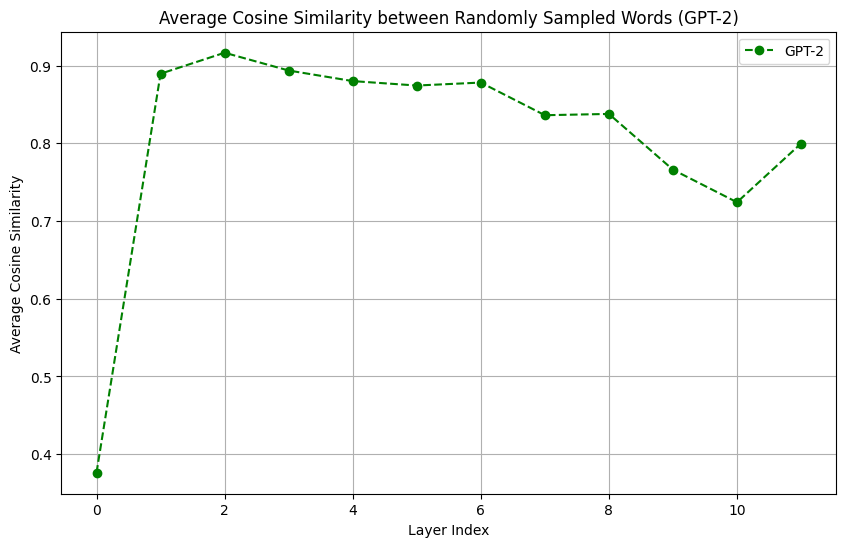

In [23]:
# Funkcja do obliczania podobieństwa kosinusowego na różnych warstwach modelu
def get_layerwise_similarity(model_name, model_class, tokenizer_class, texts):
    # Inicjalizacja modelu i tokenizera
    model = model_class.from_pretrained(model_name, output_hidden_states=True)
    tokenizer = tokenizer_class.from_pretrained(model_name)
    
    # Listy do przechowywania podobieństw na różnych warstwach
    layer_similarities = []

    for layer_idx in range(model.config.num_hidden_layers):
        similarities = []
        
        # Obliczamy osadzenia dla każdego tekstu i wybieramy losowe pary tokenów
        for text in texts:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            with torch.no_grad():
                outputs = model(**inputs)
            
            # Osadzenia z wybranej warstwy
            layer_embeddings = outputs.hidden_states[layer_idx][0]
            num_tokens = layer_embeddings.size(0)
            
            # Wybieramy losowe pary tokenów
            if num_tokens > 1:
                idx1, idx2 = np.random.choice(num_tokens, 2, replace=False)
                sim = cosine_similarity(
                    layer_embeddings[idx1].unsqueeze(0).cpu().numpy(),
                    layer_embeddings[idx2].unsqueeze(0).cpu().numpy()
                )[0][0]
                similarities.append(sim)
        
        # Średnie podobieństwo dla danej warstwy
        layer_similarities.append(np.mean(similarities))
    
    return layer_similarities

# Obliczamy średnie podobieństwa tylko dla GPT-2
model_name = "flax-community/papuGaPT2"
layer_similarities_gpt2 = get_layerwise_similarity(model_name, GPT2Model, GPT2Tokenizer, sample_texts)

# Rysowanie wykresu tylko dla GPT-2
plt.figure(figsize=(10, 6))
plt.plot(range(len(layer_similarities_gpt2)), layer_similarities_gpt2, marker='o', linestyle='--', color="green", label="GPT-2")

plt.title("Average Cosine Similarity between Randomly Sampled Words (GPT-2)")
plt.xlabel("Layer Index")
plt.ylabel("Average Cosine Similarity")
plt.legend()
plt.grid(True)
plt.show()


### Context-Specificity

### Average Self-Similarity (anisotropy-adjusted)

- Podobny do ponizszego, ale ma dostosowanie pod kątem anizotropii – przed obliczeniem podobieństwa odejmowana jest średnia wartość osadzeń
- Dzięki temu uzyskujemy bardziej wiarygodny wynik dla reprezentacji kontekstowych tokenów w obrębie zdania, eliminując wpływ nierównomiernego rozkładu wektorów w przestrzeni.
- Miara koncentruje się na podobieństwie między tokenami w zdaniu z uwzględnieniem korekty anizotropowej.

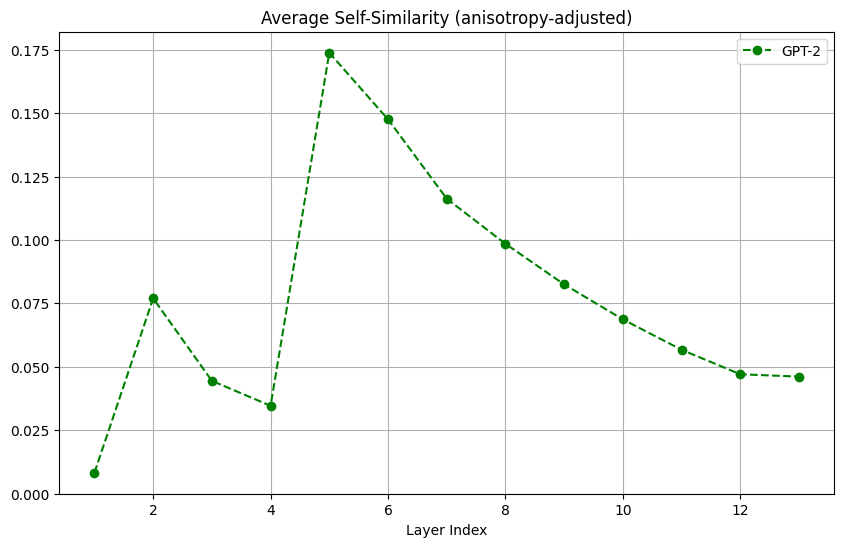

In [46]:
# Load the GPT-2 model and tokenizer
gpt2_model = GPT2Model.from_pretrained("flax-community/papuGaPT2", output_hidden_states=True)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("flax-community/papuGaPT2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Function to tokenize and get hidden states from a model with padding and truncation
def get_hidden_states(model, tokenizer, text, max_length=512):
    # Tokenize the input text with padding and truncation
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of layers (each layer is a tensor of shape [batch_size, seq_len, hidden_dim])
    return hidden_states

# Function to calculate self-similarity for each layer with optional anisotropy adjustment
def calculate_self_similarity(hidden_states, anisotropy_adjusted=True):
    layer_similarities = []
    for layer in hidden_states:
        layer = layer.squeeze(0)  # Remove batch dimension, shape is now [seq_len, hidden_dim]
        
        if anisotropy_adjusted:
            # Compute the mean embedding vector for the layer and subtract it from each token
            mean_embedding = torch.mean(layer, dim=0)
            layer = layer - mean_embedding  # Mean-centering for anisotropy adjustment
        
        num_tokens = layer.size(0)
        
        # Compute cosine similarity for each pair of tokens in the layer
        similarities = [
            1 - cosine(layer[i].cpu(), layer[j].cpu()) 
            for i in range(num_tokens) 
            for j in range(i + 1, num_tokens)
        ]
        
        # Average similarity for the current layer
        layer_similarity = np.mean(similarities)
        layer_similarities.append(layer_similarity)
    
    return layer_similarities

# Sample a subset of texts from the dataset
sample_texts = df['train']['text'][:50]  

# Compute self-similarity scores for GPT-2
gpt2_layer_similarities = []
for text in sample_texts:
    hidden_states = get_hidden_states(gpt2_model, gpt2_tokenizer, text)
    gpt2_similarities = calculate_self_similarity(hidden_states, anisotropy_adjusted=True)
    gpt2_layer_similarities.append(gpt2_similarities)

# Average the self-similarity across all samples for each layer
avg_gpt2_similarities = np.mean(gpt2_layer_similarities, axis=0)

# Plot the results
def plot_self_similarity(gpt2_similarity):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gpt2_similarity) + 1), gpt2_similarity, 'o--', label="GPT-2", color='green')
    plt.xlabel("Layer Index")
    plt.title("Average Self-Similarity (anisotropy-adjusted)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_self_similarity(avg_gpt2_similarities)

### Average Self-Similarity

- Podobieństwo między wszystkimi parami tokenów w obrębie zdania dla każdej warstwy modelu.
- Wyniki dla wszystkich zdań są uśredniane, aby uzyskać miarę podobieństwa dla każdej warstwy.
- Miara ocenia wewnętrzne podobieństwo tokenów w kontekście zdania, ale bez dostosowania pod kątem anizotropii.

In [ ]:
gpt2_model = GPT2Model.from_pretrained("flax-community/papuGaPT2", output_hidden_states=True)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("flax-community/papuGaPT2") #flax-community/papuGaPT2
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token



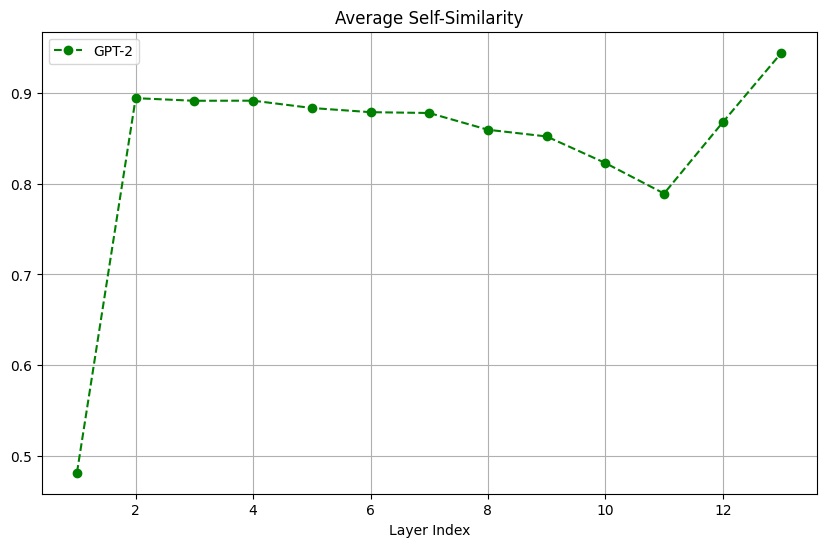

In [ ]:
# Function to tokenize and get hidden states from a model with padding and truncation
def get_hidden_states(model, tokenizer, text, max_length=512):
    # Tokenize the input text with padding and truncation
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of layers (each layer is a tensor of shape [batch_size, seq_len, hidden_dim])
    return hidden_states

# Function to calculate self-similarity for each layer
def calculate_self_similarity(hidden_states):
    layer_similarities = []
    for layer in hidden_states:
        layer = layer.squeeze(0)  # Remove batch dimension, shape is now [seq_len, hidden_dim]
        num_tokens = layer.size(0)
        
        # Compute cosine similarity for each pair of tokens in the layer
        similarities = [
            1 - cosine(layer[i].cpu(), layer[j].cpu()) 
            for i in range(num_tokens) 
            for j in range(i + 1, num_tokens)
        ]
        
        # Average similarity for the current layer
        layer_similarity = np.mean(similarities)
        layer_similarities.append(layer_similarity)
    
    return layer_similarities

# Sample a subset of texts from the dataset
sample_texts = df['train']['text'][:50]  

# Compute self-similarity scores for GPT-2
gpt2_layer_similarities = []
for text in sample_texts:
    hidden_states = get_hidden_states(gpt2_model, gpt2_tokenizer, text)
    gpt2_similarities = calculate_self_similarity(hidden_states)
    gpt2_layer_similarities.append(gpt2_similarities)

# Average the self-similarity across all samples for each layer
avg_gpt2_similarities = np.mean(gpt2_layer_similarities, axis=0)

# Plot the results
def plot_self_similarity(gpt2_similarity):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gpt2_similarity) + 1), gpt2_similarity, 'o--', label="GPT-2", color='green')
    plt.xlabel("Layer Index")
    # plt.ylabel("Average Self-Similarity")
    plt.title("Average Self-Similarity") 
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_self_similarity(avg_gpt2_similarities)


-----------------------------------------------------

## dla GPT2

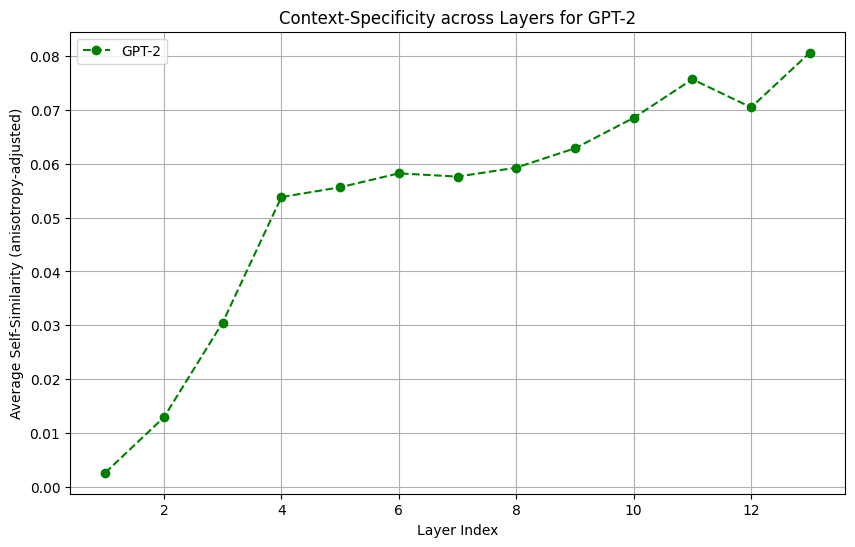

In [4]:
# Import necessary libraries
from datasets import load_dataset
from transformers import GPT2Model, GPT2Tokenizer
import torch
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import numpy as np

# Load the GPT-2 model and tokenizer
gpt2_model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# Function to tokenize and get hidden states from a model with padding and truncation
def get_hidden_states(model, tokenizer, text, max_length=512):
    # Tokenize the input text with padding and truncation
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of layers (each layer is a tensor of shape [batch_size, seq_len, hidden_dim])
    return hidden_states

# Function to calculate self-similarity for each layer with optional anisotropy adjustment
def calculate_self_similarity(hidden_states, anisotropy_adjusted=True):
    layer_similarities = []
    for layer in hidden_states:
        layer = layer.squeeze(0)  # Remove batch dimension, shape is now [seq_len, hidden_dim]
        
        if anisotropy_adjusted:
            # Compute the mean embedding vector for the layer and subtract it from each token
            mean_embedding = torch.mean(layer, dim=0)
            layer = layer - mean_embedding  # Mean-centering for anisotropy adjustment
        
        num_tokens = layer.size(0)
        
        # Compute cosine similarity for each pair of tokens in the layer
        similarities = [
            1 - cosine(layer[i].cpu(), layer[j].cpu()) 
            for i in range(num_tokens) 
            for j in range(i + 1, num_tokens)
        ]
        
        # Average similarity for the current layer
        layer_similarity = np.mean(similarities)
        layer_similarities.append(layer_similarity)
    
    return layer_similarities

# Sample a subset of texts from the dataset
sample_texts = df['train']['text'][:50]  

# Compute self-similarity scores for GPT-2
gpt2_layer_similarities = []
for text in sample_texts:
    hidden_states = get_hidden_states(gpt2_model, gpt2_tokenizer, text)
    gpt2_similarities = calculate_self_similarity(hidden_states, anisotropy_adjusted=True)
    gpt2_layer_similarities.append(gpt2_similarities)

# Average the self-similarity across all samples for each layer
avg_gpt2_similarities = np.mean(gpt2_layer_similarities, axis=0)

# Plot the results
def plot_self_similarity(gpt2_similarity):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gpt2_similarity) + 1), gpt2_similarity, 'o--', label="GPT-2", color='green')
    plt.xlabel("Layer Index")
    plt.title("Average Self-Similarity (anisotropy-adjusted)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_self_similarity(avg_gpt2_similarities)


In [39]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")


In [40]:
layer_similarities = {}

model.config.output_hidden_states = True

layer_similarities = {}

# Wybierz przykładowe zdania z korpusu
texts = [example["text"] for example in df["train"].select(range(300))]  


# Process each text
for text in texts:
    # Tokenize and get model outputs with hidden states for each layer
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)

    # Select a random word from the tokenized input (not [CLS] or [SEP])
    input_ids = inputs["input_ids"][0].tolist()
    random_word_index = random.randint(1, len(input_ids) - 2)  # Exclude CLS and SEP tokens

    # Iterate over each layer and extract the embedding for the random word
    for layer_index, hidden_state in enumerate(outputs.hidden_states):
        word_embedding = hidden_state[0, random_word_index, :].detach().numpy()
        
        if layer_index not in layer_similarities:
            layer_similarities[layer_index] = []
        
        layer_similarities[layer_index].append(word_embedding)

# Calculate mean and std deviation of cosine similarity for each layer
mean_similarities = []
std_similarities = []

for layer_index, embeddings in layer_similarities.items():
    embeddings = np.vstack(embeddings)
    cosine_similarities = cosine_similarity(embeddings)
    similarity_values = cosine_similarities[np.triu_indices_from(cosine_similarities, k=1)]
    
    mean_similarity = np.mean(similarity_values)
    std_similarity = np.std(similarity_values)
    
    mean_similarities.append(mean_similarity)
    std_similarities.append(std_similarity)


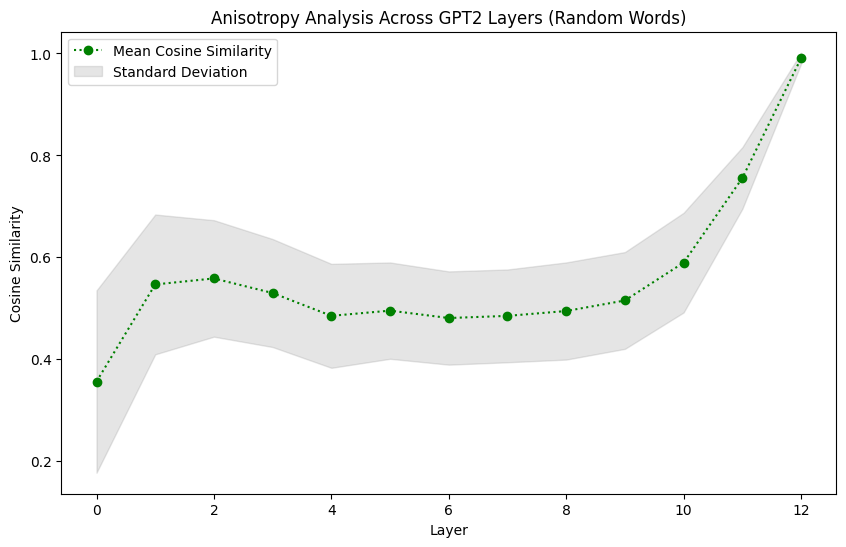

In [41]:
# Plot the results
layers = list(range(len(mean_similarities)))

plt.figure(figsize=(10, 6))
plt.plot(layers, mean_similarities, label='Mean Cosine Similarity', linestyle=':', color='green', marker='o', markersize=6)
plt.fill_between(layers, 
                 np.array(mean_similarities) - np.array(std_similarities), 
                 np.array(mean_similarities) + np.array(std_similarities), 
                 color='gray', alpha=0.2, label='Standard Deviation')
plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.title("Anisotropy Analysis Across GPT2 Layers (Random Words)")
plt.legend()
plt.show()

In [15]:
gpt2_model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2") #flax-community/papuGaPT2
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

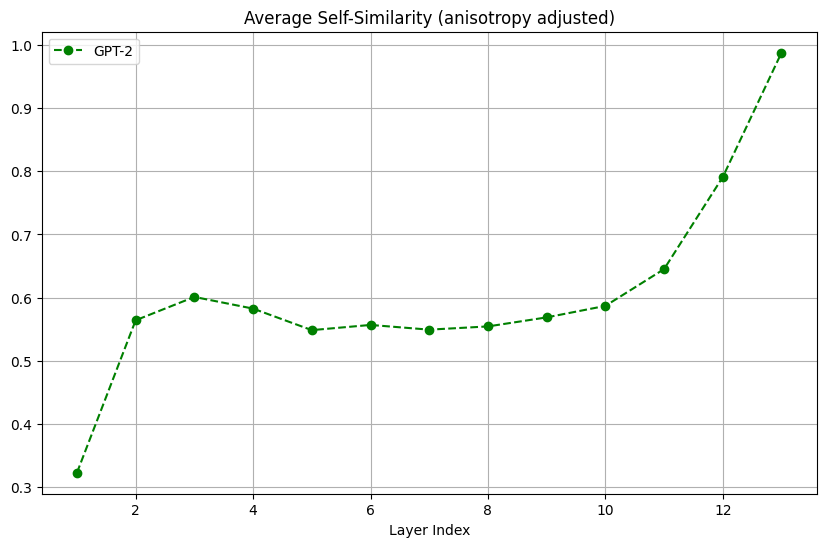

In [16]:
# Function to tokenize and get hidden states from a model with padding and truncation
def get_hidden_states(model, tokenizer, text, max_length=512):
    # Tokenize the input text with padding and truncation
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    hidden_states = outputs.hidden_states  # Tuple of layers (each layer is a tensor of shape [batch_size, seq_len, hidden_dim])
    return hidden_states

# Function to calculate self-similarity for each layer
def calculate_self_similarity(hidden_states):
    layer_similarities = []
    for layer in hidden_states:
        layer = layer.squeeze(0)  # Remove batch dimension, shape is now [seq_len, hidden_dim]
        num_tokens = layer.size(0)
        
        # Compute cosine similarity for each pair of tokens in the layer
        similarities = [
            1 - cosine(layer[i].cpu(), layer[j].cpu()) 
            for i in range(num_tokens) 
            for j in range(i + 1, num_tokens)
        ]
        
        # Average similarity for the current layer
        layer_similarity = np.mean(similarities)
        layer_similarities.append(layer_similarity)
    
    return layer_similarities

# Sample a subset of texts from the dataset
sample_texts = df['train']['text'][:50] 

# Compute self-similarity scores for GPT-2
gpt2_layer_similarities = []
for text in sample_texts:
    hidden_states = get_hidden_states(gpt2_model, gpt2_tokenizer, text)
    gpt2_similarities = calculate_self_similarity(hidden_states)
    gpt2_layer_similarities.append(gpt2_similarities)

# Average the self-similarity across all samples for each layer
avg_gpt2_similarities = np.mean(gpt2_layer_similarities, axis=0)

# Plot the results
def plot_self_similarity(gpt2_similarity):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(gpt2_similarity) + 1), gpt2_similarity, 'o--', label="GPT-2", color='green')
    plt.xlabel("Layer Index")
    # plt.ylabel("Average Self-Similarity")
    plt.title("Average Self-Similarity (anisotropy adjusted)") #Context-Specificity across Layers for GPT-2
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the plotting function
plot_self_similarity(avg_gpt2_similarities)
